In [1]:
import sys
sys.path.append('..')
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from connattractor import network, analysis


In [2]:
with open('../data_out/default_hopfield_embedding_0.37.pkl', 'rb') as file:
    hopfield_embedding = pickle.load(file)

In [3]:
from sklearn.preprocessing import StandardScaler

_fd_thr = 0.15
_perc_scrub_thr = 0.5

rest = np.repeat(np.nan, 122)
task = np.repeat(np.nan, 122)
temperatures = [np.nan]
sub_rest = [np.nan]
sub_task = [np.nan]

_TR_ = 2.0 # seconds

for sub in range(1,33):
    sub_pad = f'{sub+1:02}'
    fd = pd.read_csv('../data_in/ex_timeseries_task/sub-' + sub_pad + '_FD.txt').values.flatten()
    fd = np.hstack(([0], fd))
    ts = pd.read_csv('../data_in/ex_timeseries_task/sub-' + sub_pad + '_ts.txt', sep='\t').iloc[:, 1:].values
    events = pd.read_csv('../data_in/ex_timeseries_task/sub-' + sub_pad + '_task-heatpainwithregulationandratings_run-01_events.tsv',
                        sep='\t')
    
    ts = StandardScaler().fit_transform(ts)

    if np.sum(fd>_fd_thr)/len(fd) < _perc_scrub_thr:
        ts[fd>=_fd_thr] = np.nan
    else:
        ts[:] = np.nan
        print('perc. scrubbed:', np.sum(fd>_fd_thr)/len(fd))
        
    # task timeframes: same duration, 6 sec delay in onset due to HRF
    # rest timeframes: starts 6 sec after last block, right until the onset of the next block
    
    rest_block = ts[0:(int(np.round(18+2/_TR_))), :]
    rest = np.vstack((rest, rest_block))
    sub_rest += [sub] * rest_block.shape[0]
    
    for i in events.index: 
        
        onset = int(np.round(events.loc[i, "onset"]/_TR_))
        end = onset + int(np.round(events.loc[i, "duration"]/_TR_))
        
        if not np.isnan(events.loc[i, "temperature"]):
            # early phase
            current_block = ts[(onset+int(np.round(8/_TR_))):(onset+int(np.round(16/_TR_))), :]
            task = np.vstack((task, current_block))
            temperatures += [events.loc[i, "temperature"]]*current_block.shape[0]
            sub_task += [sub] * current_block.shape[0]

temperatures = np.array(temperatures)[~np.ma.fix_invalid(task).mask.any(axis=1)]
sub_rest = np.array(sub_rest)[~np.ma.fix_invalid(rest).mask.any(axis=1)]
sub_task = np.array(sub_task)[~np.ma.fix_invalid(task).mask.any(axis=1)]
task = task[~np.ma.fix_invalid(task).mask.any(axis=1)]
rest = rest[~np.ma.fix_invalid(rest).mask.any(axis=1)]
rest.shape, task.shape, np.unique(temperatures), len(sub_rest)

perc. scrubbed: 0.8133971291866029
perc. scrubbed: 0.5741626794258373
perc. scrubbed: 0.6267942583732058
perc. scrubbed: 0.7081339712918661


((405, 122), (1052, 122), array([42.3, 43.3, 44.3, 45.3, 46. , 46.3]), 405)

In [4]:
def calc_tmat(att_labels, num_states=None):
    if num_states == None:
        num_states = len(np.unique(att_labels))
        
    transition_matrix = np.zeros((num_states, num_states))

    for i in range(len(att_labels) - 1):
        current_state = att_labels[i]
        next_state = att_labels[i + 1]
        transition_matrix[current_state, next_state] += 1

    transition_matrix /= transition_matrix.sum(axis=1, keepdims=True)
    return transition_matrix


In [5]:
def fiter_repeat_frames(labels):
    filtered_sequence = []
    previous_state = None

    for state in labels:
        if state != previous_state:
            filtered_sequence.append(state)
        previous_state = state

    return filtered_sequence

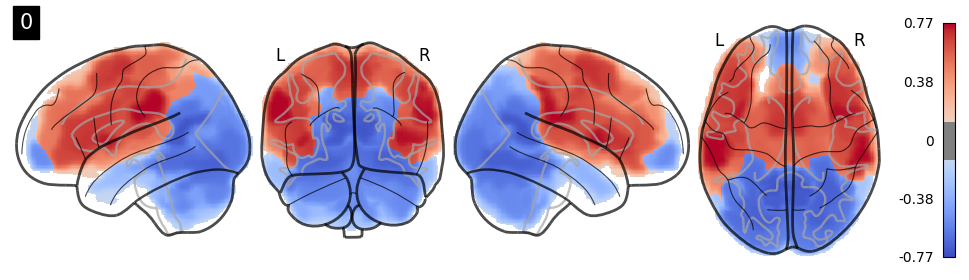

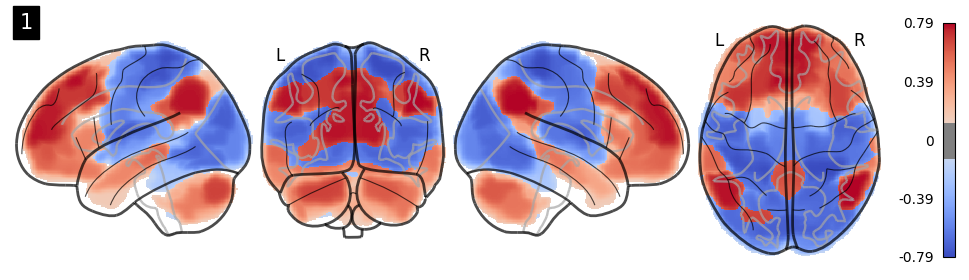

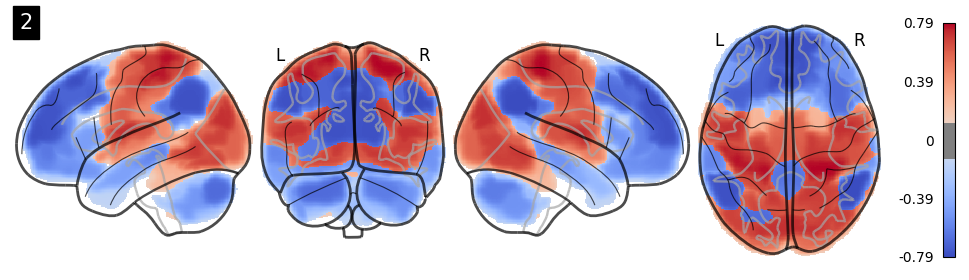

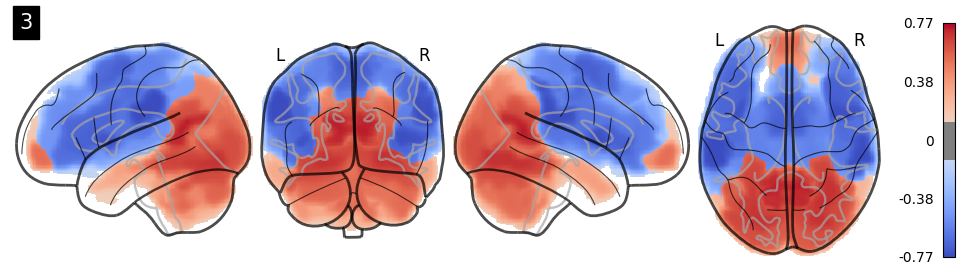

In [6]:
for k, v in hopfield_embedding.attractors.items():
    ax = network.State(v).plot(title=str(k))
    plt.show()

# Task

In [7]:
embedded_task = hopfield_embedding.embedding_model.transform(task)[:, :2]
labels_task = hopfield_embedding.attractor_model.predict(embedded_task)

tmat_task = calc_tmat(labels_task)
print(tmat_task)

[[0.44680851 0.31914894 0.21808511 0.01595745]
 [0.1278826  0.67085954 0.16142558 0.03983229]
 [0.13057325 0.22611465 0.57324841 0.07006369]
 [0.02777778 0.34722222 0.22222222 0.40277778]]


[Text(0.5, 23.52222222222222, 'to state'),
 Text(50.722222222222214, 0.5, 'from state')]

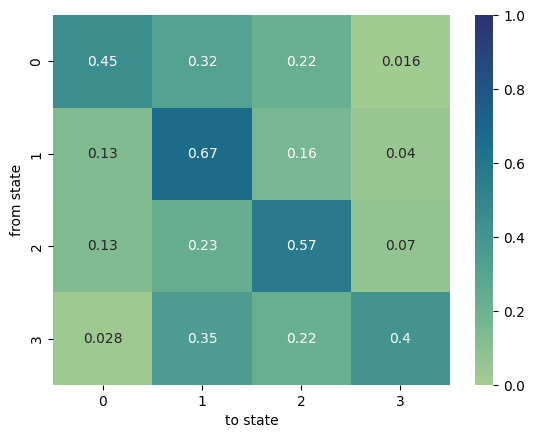

In [8]:
import seaborn as sns

ax = sns.heatmap(tmat_task, cmap="crest", vmin=0, vmax=1, annot=True)
ax.set(xlabel="to state", ylabel="from state")

In [9]:
labels_task_filt = fiter_repeat_frames(labels_task)

In [10]:
tmat_task_filt = calc_tmat(labels_task_filt)
print(tmat_task_filt)

[[0.         0.57692308 0.39423077 0.02884615]
 [0.38853503 0.         0.49044586 0.12101911]
 [0.30597015 0.52985075 0.         0.1641791 ]
 [0.04651163 0.58139535 0.37209302 0.        ]]


[Text(0.5, 23.52222222222222, 'to state'),
 Text(50.722222222222214, 0.5, 'from state')]

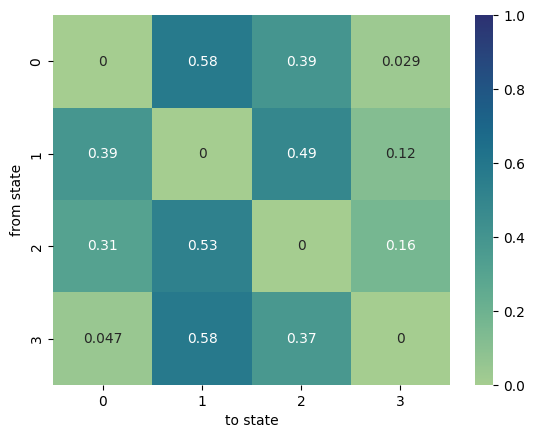

In [11]:
ax = sns.heatmap(tmat_task_filt, cmap="crest", vmin=0, vmax=1, annot=True)
ax.set(xlabel="to state", ylabel="from state")

# Rest

In [13]:
rest_embedded = hopfield_embedding.embedding_model.transform(rest)[:, :2]
labels_rest = hopfield_embedding.attractor_model.predict(rest_embedded)

tmat_rest = calc_tmat(labels_rest, 4)
print(tmat_rest)

[[0.46938776 0.32653061 0.18367347 0.02040816]
 [0.07784431 0.7005988  0.1257485  0.09580838]
 [0.08609272 0.14569536 0.71523179 0.05298013]
 [0.         0.32432432 0.37837838 0.2972973 ]]


[Text(0.5, 23.52222222222222, 'to state'),
 Text(50.722222222222214, 0.5, 'from state')]

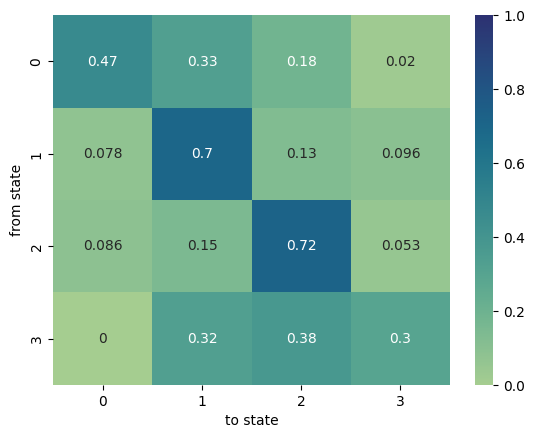

In [14]:
ax = sns.heatmap(tmat_rest, cmap="crest", vmin=0, vmax=1, annot=True)
ax.set(xlabel="to state", ylabel="from state")

[Text(0.5, 23.52222222222222, 'to state'),
 Text(50.722222222222214, 0.5, 'from state')]

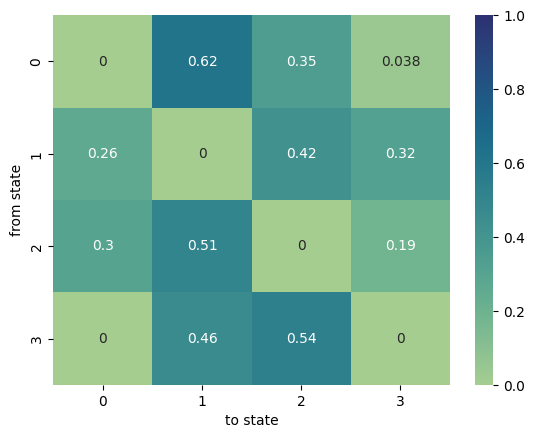

In [15]:
labels_rest_filt = fiter_repeat_frames(labels_rest)
tmat_rest_filt = calc_tmat(labels_rest_filt)

ax = sns.heatmap(tmat_rest_filt, cmap="crest", vmin=0, vmax=1, annot=True)
ax.set(xlabel="to state", ylabel="from state")

# difference

[Text(0.5, 23.52222222222222, 'to state'),
 Text(50.722222222222214, 0.5, 'from state')]

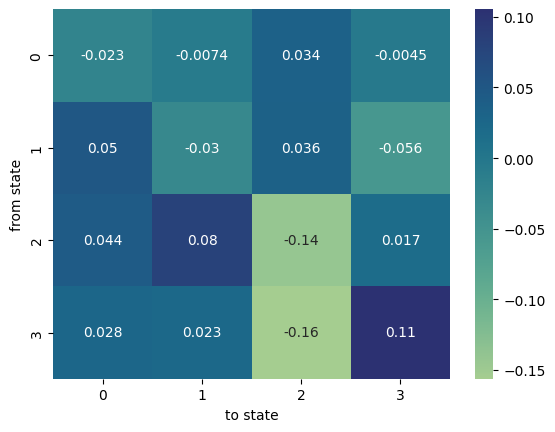

In [16]:
ax = sns.heatmap(tmat_task-tmat_rest, cmap="crest", annot=True)
ax.set(xlabel="to state", ylabel="from state")

[Text(0.5, 23.52222222222222, 'to state'),
 Text(50.722222222222214, 0.5, 'from state')]

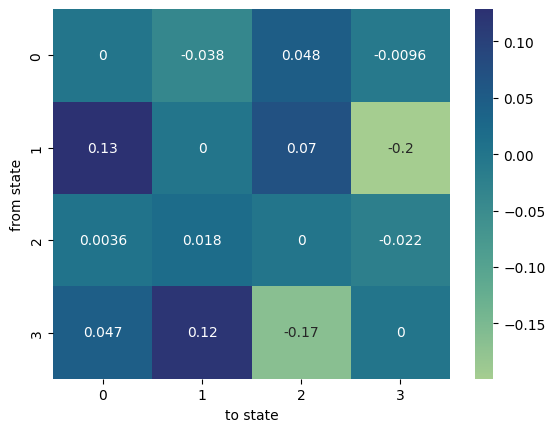

In [17]:
ax = sns.heatmap(tmat_task_filt-tmat_rest_filt, cmap="crest", annot=True)
ax.set(xlabel="to state", ylabel="from state")

## count repeated frames

In [18]:
state_repeated_counts = {}

current_state = None

for state in labels_task:
    if state == current_state:
        if state in state_repeated_counts:
            state_repeated_counts[state] += 1
        else:
            state_repeated_counts[state] = 1
    current_state = state

repeated_states = {state: count for state, count in state_repeated_counts.items() if count >= 1}

for state, count in repeated_states.items():
    print(f"State {state} is repeated at least once {count} times.")


State 1 is repeated at least once 320 times.
State 0 is repeated at least once 84 times.
State 2 is repeated at least once 180 times.
State 3 is repeated at least once 29 times.


In [19]:
state_repeated_counts = {}

current_state = None

for state in labels_rest:
    if state == current_state:
        if state in state_repeated_counts:
            state_repeated_counts[state] += 1
        else:
            state_repeated_counts[state] = 1
    current_state = state

repeated_states = {state: count for state, count in state_repeated_counts.items() if count >= 1}

for state, count in repeated_states.items():
    print(f"State {state} is repeated at least once {count} times.")


State 1 is repeated at least once 117 times.
State 2 is repeated at least once 108 times.
State 0 is repeated at least once 23 times.
State 3 is repeated at least once 11 times.


# some stats

### unfiltered

In [22]:
tmat_task = calc_tmat(labels_task)
tmat_rest = calc_tmat(labels_rest)

norm_ref = np.linalg.norm(tmat_task-tmat_rest)



0.27434725353788214

In [39]:
n_perm = 1000

random = np.random.default_rng(289)
null_dist = []
for i in range(n_perm):
    labels_perm = labels_task.copy()
    np.random.shuffle(labels_perm)
    tmat_perm = calc_tmat(labels_perm)
    null_dist.append(np.linalg.norm(tmat_perm-tmat_rest))
    

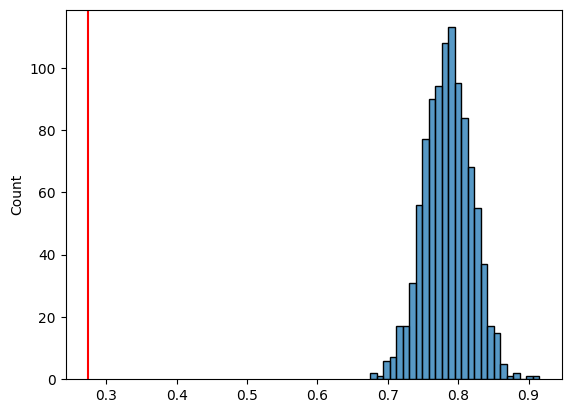

p =  0.0


In [41]:
sns.histplot(null_dist)
plt.axvline(norm_ref, color='red')
plt.show()
print('p = ', np.sum(np.array(null_dist) < norm_ref) / n_perm)

### filtered for repeated frames

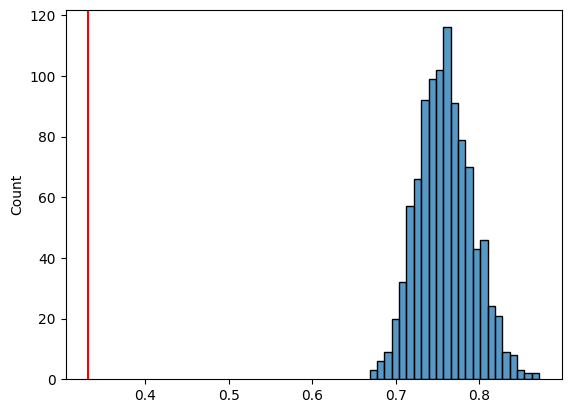

p =  0.0


In [42]:
tmat_task_filt = calc_tmat(labels_task_filt)
tmat_rest_filt = calc_tmat(labels_rest_filt)

norm_ref = np.linalg.norm(tmat_task_filt-tmat_rest_filt)

n_perm = 1000

random = np.random.default_rng(289)
null_dist = []

for i in range(n_perm):
    labels_perm = labels_task.copy()
    np.random.shuffle(labels_perm)
    tmat_perm = calc_tmat(labels_perm)
    null_dist.append(np.linalg.norm(tmat_perm-tmat_rest_filt))

sns.histplot(null_dist)
plt.axvline(norm_ref, color='red')
plt.show()
print('p = ', np.sum(np.array(null_dist) < norm_ref) / n_perm)